In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

assert True == torch.cuda.is_available()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [4]:
class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize((128, 128, 128), (128, 128, 128))
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            # v2.RandomGrayscale(0.3),
            # v2.RandomPhotometricDistort(saturation=[1, 1.5], hue = [0,0], brightness=[0.875, 1.125], contrast=[0.9,1.1], p = 0.3),
            # v2.ColorJitter(saturation=[1, 1], hue = 0, brightness=[1, 1], contrast=[0.9,1.1])
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device)
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.2, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [5]:
train_loader = DataLoader(train_dataset, 64, True)
val_loader = DataLoader(val_dataset, 64, True)

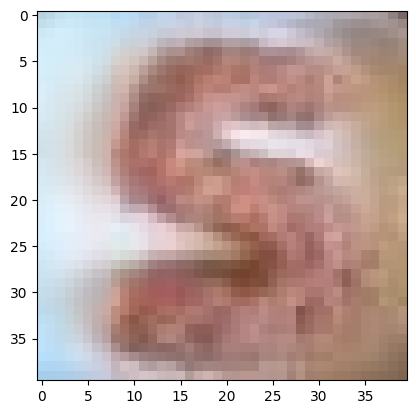

torch.Size([3, 40, 40])


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(img.shape)

imshow(train_dataset[2][0])


In [7]:
# for data, target in train_loader:
#     print(data)
#     print(target)
#     break

In [8]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in loader:

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)  # use this loss for any training statistics
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch + 1}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model, "model.pth")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [9]:
# net = resnet18(num_classes=200)

# net.maxpool = nn.ReLU()
# net.conv1.stride = (1, 1)
# net.layer2[0].conv1.stride = (1, 1)
# net.layer2[0].downsample[0].stride = (1, 1)

# net.layer3[0].conv2.stride = (1, 1)
# net.layer3[0].downsample[0].stride = (1, 1)

# net.layer4[0].conv2.stride = (1, 1)
# net.layer4[0].downsample[0].stride = (1, 1)

# print(net)

In [10]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)

print(net)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
# net = efficientnet_v2_s(num_classes=200)

# net(torch.zeros((64, 3, 40, 40), dtype=torch.float).to(device)).shape

In [12]:
net = net.to(device)

In [13]:
torch.manual_seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)
torch.backends.cudnn.deterministic = True

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 15)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 15, train_loader, val_loader, scheduler)

100%|██████████| 1250/1250 [04:22<00:00,  4.76it/s]


Epoch 1
 train loss: 5.078454494476318, train acc: 0.023074999451637268
 val loss: 4.891274929046631, val acc: 0.048921726644039154



100%|██████████| 1250/1250 [04:14<00:00,  4.91it/s]


Epoch 2
 train loss: 4.5690531730651855, train acc: 0.06584999710321426
 val loss: 4.294604301452637, val acc: 0.09265175461769104



100%|██████████| 1250/1250 [04:14<00:00,  4.91it/s]


Epoch 3
 train loss: 4.188443183898926, train acc: 0.11264999955892563
 val loss: 3.94588303565979, val acc: 0.14546725153923035



100%|██████████| 1250/1250 [04:15<00:00,  4.90it/s]


Epoch 4
 train loss: 3.798391342163086, train acc: 0.16718749701976776
 val loss: 3.5378313064575195, val acc: 0.20931509137153625



100%|██████████| 1250/1250 [04:21<00:00,  4.78it/s]


Epoch 5
 train loss: 3.4723429679870605, train acc: 0.21626250445842743
 val loss: 3.2825794219970703, val acc: 0.24965055286884308



100%|██████████| 1250/1250 [04:17<00:00,  4.85it/s]


Epoch 6
 train loss: 3.2207999229431152, train acc: 0.25917500257492065
 val loss: 3.130772829055786, val acc: 0.28144967555999756



100%|██████████| 1250/1250 [04:14<00:00,  4.91it/s]


Epoch 7
 train loss: 3.0077080726623535, train acc: 0.29600000381469727
 val loss: 2.9950742721557617, val acc: 0.30166733264923096



100%|██████████| 1250/1250 [04:18<00:00,  4.83it/s]


Epoch 8
 train loss: 2.8124258518218994, train acc: 0.3332499861717224
 val loss: 2.894453525543213, val acc: 0.3245307505130768



100%|██████████| 1250/1250 [04:27<00:00,  4.68it/s]


Epoch 9
 train loss: 2.639960289001465, train acc: 0.3685374855995178
 val loss: 2.831690788269043, val acc: 0.33795925974845886



100%|██████████| 1250/1250 [04:25<00:00,  4.70it/s]


Epoch 10
 train loss: 2.4801363945007324, train acc: 0.39969998598098755
 val loss: 2.711717128753662, val acc: 0.36376798152923584



100%|██████████| 1250/1250 [04:24<00:00,  4.72it/s]


Epoch 11
 train loss: 2.331209659576416, train acc: 0.42925000190734863
 val loss: 2.668144464492798, val acc: 0.37345248460769653



100%|██████████| 1250/1250 [04:22<00:00,  4.77it/s]


Epoch 12
 train loss: 2.1915793418884277, train acc: 0.458112508058548
 val loss: 2.621119499206543, val acc: 0.3846845030784607



100%|██████████| 1250/1250 [04:14<00:00,  4.91it/s]


Epoch 13
 train loss: 2.0735199451446533, train acc: 0.4844624996185303
 val loss: 2.599186658859253, val acc: 0.3930211663246155



100%|██████████| 1250/1250 [04:25<00:00,  4.71it/s]


Epoch 14
 train loss: 1.9804140329360962, train acc: 0.5059000253677368
 val loss: 2.5832748413085938, val acc: 0.39601635932922363



100%|██████████| 1250/1250 [04:32<00:00,  4.58it/s]


Epoch 15
 train loss: 1.9312562942504883, train acc: 0.5188375115394592
 val loss: 2.5733046531677246, val acc: 0.3975139856338501



In [14]:
# net = torch.load("model.pth", weights_only=False)
# net = net.to(device)

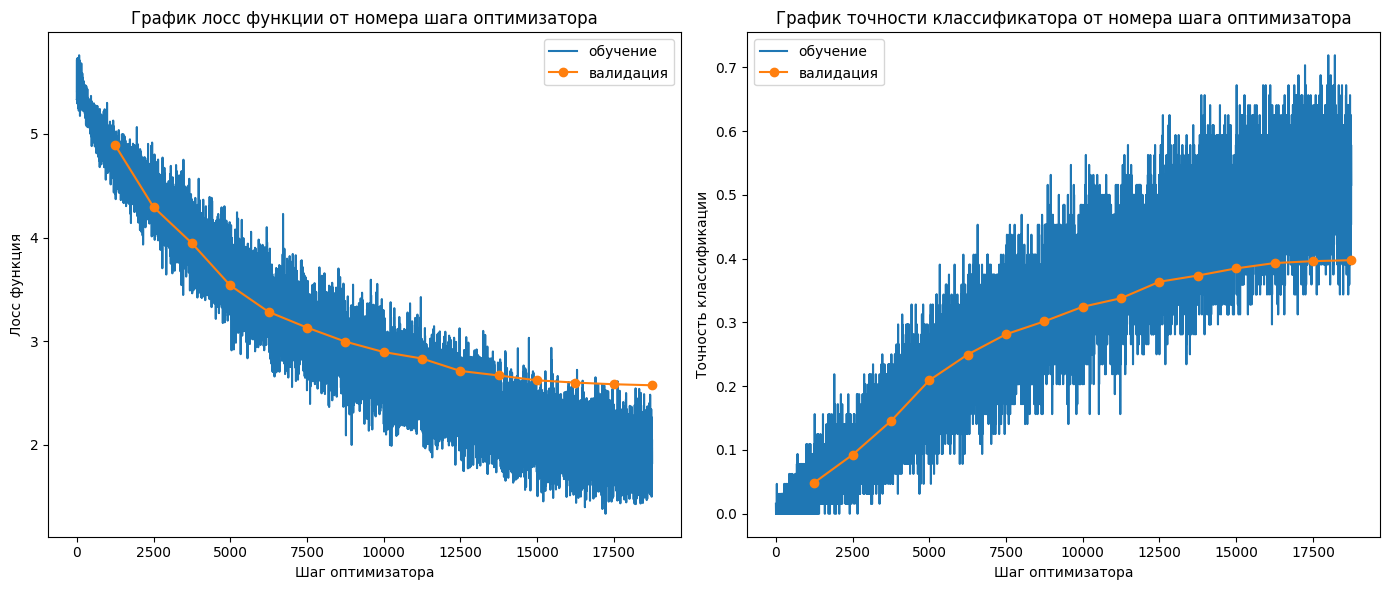

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация", marker = "o")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация", marker = "o")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].legend()
plt.tight_layout()
plt.show()

In [16]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        transform = v2.Normalize((128, 128, 128), (128, 128, 128))
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
        img = transform(img).unsqueeze(0)
        logits = net(img)[0]
        pred.append(int(logits.argmax().to("cpu")))


100%|██████████| 10000/10000 [03:24<00:00, 48.99it/s]


In [17]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [18]:
df.to_csv("labels_test.csv", index=False)